In [4]:
import os
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
from statistics import mean, median
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats 

In [5]:
nx.__version__

'2.8.8'

In [6]:
pd.__version__

'1.4.4'

In [7]:
np.__version__

'1.21.5'

In [8]:
os.chdir(r"C:\DSM160_CW1")
str_path = os.getcwd()

In [9]:
str_path

'C:\\DSM160_CW1'

## Define functions

In [10]:
### function to obtain average degree of network
def average_degree(G):
    return mean(dict(G.degree()).values())

In [11]:
# Function to obtain a neighbors' dictionary
def neighbors_dict(G):
    if nx.is_directed(G):
        return {n:{'in':list(G.predecessors(n)), 'out':list(G.successors(n))} for n in G.nodes}
    else:
        return {n:list(G.neighbors(n)) for n in G.nodes}

In [12]:
# Function to invert a dictionary
# warning: dictionary to invert must contain scalar values
def invert_dict(d):
    inverse = {}
    for key in d:
        val = d[key]
        if val not in inverse:
            inverse[val] = [key]
        else:
            inverse[val].append(key)
    # sort the keys of inverted dictionary
    ord_inverse = {}
    for key in sorted(inverse):
        ord_inverse[key] = inverse[key]
    #
    return ord_inverse

In [13]:
# Function to plot a network using pyvis
def plot_G_pyvis(G, file_path = str_path + '/G.html', bln_weighted = False, bln_display_weights = False, height_px = '1000px', width_px = '1000px'):
    bln_directed = nx.is_directed(G)
    #
    nt = Network('1000px', '1000px', directed = bln_directed)
    nt.from_nx(G) # imports graph from networkx
    # nt.nodes is a list of dictionaries
    for n in nt.nodes:
        n['label'] = str(n['label'])
    #
    # nt.edges is a list of dictionaries
    if bln_weighted:
        for e in nt.edges:
            e['value'] = e['weight']
        if bln_display_weights:
            for e in nt.edges:
                e['label'] = str(e['value'])
    if bln_directed and bln_weighted:
        for e in nt.edges:
            e['arrowStrikethrough'] = False
    #
    nt.toggle_physics(False) # to avoid initial slow rendering
    # to activate forceAtlas2Based and interaction options
    nt.show_buttons(filter_=['physics', 'interaction'])
    nt.show(file_path)

In [70]:
# Compute centrality concepts for undirected, unweighted graph and store in a pandas dataframe
def G_centrality_pd(G):
    C_degree = dict(nx.degree(G))
    C_close = dict(nx.closeness_centrality(G, wf_improved=True))
    C_btw = dict(nx.betweenness_centrality(G, normalized=True))
    #
    pd_C_degree = pd.DataFrame.from_dict(C_degree, orient='index', columns=['Degree']).sort_index()
    pd_C_close = pd.DataFrame.from_dict(C_close, orient='index', columns=['Closeness']).sort_index()
    pd_C_btw = pd.DataFrame.from_dict(C_btw, orient='index', columns=['Betweenness']).sort_index()
    #
    pd_C = pd.concat([pd_C_degree, pd_C_close, pd_C_btw], axis=1)
    return pd_C
#
# Function that returns average degree of a node's neighbors
def average_degree_neighbors(G, node):
    avg_degree_neighbor = 0
    node_neighbors = list(G.neighbors(node))
    if len(node_neighbors) > 0: # if the node has neighbors
        sum_degree_neighbors = 0
        for neighbor in node_neighbors:
            sum_degree_neighbors += G.degree(neighbor)
        avg_degree_neighbor = sum_degree_neighbors/len(node_neighbors)
    return avg_degree_neighbor
#
# Function to obtain degree histogram values:
# degree values on the x-axis, number of nodes having that degree on the y-axis
def degree_histogram(degree_sequence, bln_normalised = True):
    degree_counts = Counter(degree_sequence)
    # sorted(list(degree_counts))
    min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())
    plot_x = list(range(min_degree, max_degree + 1))
    ncounts = 1
    if bln_normalised:
        # total number of counts to normalise
        ncounts = sum(degree_counts.values())
    plot_y = [degree_counts.get(x, 0)/ncounts for x in plot_x]
    return plot_x, plot_y
#
# Function to calculate the (complementary) cumulative probabilities -- CCDF(k)
def cumulative_prob(degree_sequence):
    degree_counts = Counter(degree_sequence)
    sorted_degrees = sorted(list(degree_counts))
    N = len(degree_sequence)
    remaining = N
    cumcount = {}
    for d in sorted_degrees:
        cumcount[d] = remaining/N
        remaining -= degree_counts[d]
    return cumcount
#
def pd_degree_mixing_matrix(G):
    # obtained ordered list of possible degrees
    G_degrees = sorted(list({d for _,d in G.degree(G.nodes, weight='weight')}))
    # order index for possible degree values to pass to NetworkX function
    G_mapping = {G_degrees[i]: i for i in range(0,len(G_degrees))}
    # obtain the mixing matrix between attribute values
    G_E = nx.degree_mixing_matrix(G, mapping = G_mapping)
    # G_E.sum() # the sum equals to 1
    # Turn matrix into a pandas DataFrame
    pd_rowcolnames = ['d_' + str(key) for key in G_mapping]
    pd_G_E = pd.DataFrame(G_E, index=pd_rowcolnames, columns=pd_rowcolnames)
    return pd_G_E
#
# Function to transform nearest-neighbor dictionary (knn_dict)
# into a pandas dataframe (knn_pd)
def knn_dict_to_pd(knn_dict):
    knn_pd = {}
    knn_pd = pd.DataFrame.from_dict(knn_dict, orient='index', columns=['knn']).sort_index()
    knn_pd.insert(0,'k',knn_pd.index) # insert index as first column
    knn_pd.reset_index(drop=True, inplace=True) # delete current index
    return knn_pd
#
# Function to build pandas dataframe of bilateral short-path lengths (SPLs)
# dict_sp_G = dict(nx.shortest_path_length(G))
def SPL_dict_to_pd(dict_sp_G):
    pd_SPL = pd.DataFrame.from_dict(dict_sp_G).sort_index()
    # NaN become infinite length
    pd_SPL.fillna(np.inf, inplace = True)
    # for a "source/target" structure
    pd_SPL = pd_SPL.transpose()
    pd_SPL.sort_index(inplace = True)
    return pd_SPL # dataframe of bilateral SPLs
#
# Function to find shortest paths and lengths
def BFS(G, s): # Breadth-First Search
    # uses function: neighbors_dict(G)
    d_path_lengths = {}
    path_list = {}
    if nx.is_connected(G): # if graph is connected
        G_neighbors = neighbors_dict(G)
        l_dist = {n:{'dist':-1} for n in G.nodes}
        l_dist[s]['dist'] = 0
        SPT = nx.DiGraph() # create shortest path tree
        SPT.add_node(s) # add source node
        l_frontier = []
        l_frontier.append(s)
        while len(l_frontier)>0:
            cur_node = l_frontier[0]
            l_frontier.remove(cur_node)
            for n in G_neighbors[cur_node]:
                if l_dist[n]['dist'] == -1:
                    l_frontier.append(n)
                    l_dist[n]['dist'] = l_dist[cur_node]['dist'] + 1
                    SPT.add_edge(cur_node, n)
        #
        # plot_G_pyvis(SPT, str_path + '/SPT.html')
        # SPT_neighbors = neighbors_dict(SPT) # SPT
        # l_dist # path lengths
        d_path_lengths = {n:l_dist[n]['dist'] for n in l_dist}
        d_path_lengths = dict(sorted(d_path_lengths.items(), key=lambda dict_item: dict_item[1]))
        # dictionary of path lengths (increasing distance)
        # d_path_lengths
        #
        # Reconstruct paths:
        # A reversed graph for the SP tree
        SPT_reverse = SPT.reverse(copy=True)
        SPT_reverse_neighbors = neighbors_dict(SPT_reverse)
        #
        # Build dictionary of shortest path lists
        path_list = {(s,n):[] for n in d_path_lengths.keys()}
        #
        for n in d_path_lengths:
            n_links = d_path_lengths[n]
            l_path = []
            cur_node = n
            l_path.append(cur_node)
            for i in range(n_links):
                next_node = SPT_reverse_neighbors[cur_node]['out']
                l_path.append(next_node[0])
                cur_node = next_node[0]
            l_path.reverse()
            path_list[(s,n)] = l_path
        #
    return (path_list, d_path_lengths)

### Question 2: Import the data into Python using pandas library and convert it into a networkx graph

In [15]:
train_lines = pd.read_csv('/DSM160_CW1/london_transport_raw.edges',
                 header=None,
                 keep_default_na=False,
                 names=['line','source','target'],
                 sep=' ')                         
train_lines

line             source           target
0    bakerloo  harrow&wealdstone           kenton
1    bakerloo             kenton      southkenton
2    bakerloo        southkenton     northwembley
3    bakerloo       northwembley   wembleycentral
4    bakerloo     wembleycentral  stonebridgepark
..        ...                ...              ...
498       dlr             poplar        blackwall
499       dlr          blackwall        eastindia
500       dlr          eastindia      canningtown
501       dlr               bank         shadwell
502       dlr          westferry    westindiaquay

[503 rows x 3 columns]

In [16]:
stations = pd.read_csv('/DSM160_CW1/london_transport_nodes.txt',
                       header=0,
                       names=['stationID','name','lat', 'long'],
                       sep=' ')
stations

stationID               name        lat      long
0            0          abbeyroad  51.531952  0.003738
1            1            westham  51.528526  0.005332
2            2       actoncentral  51.508758 -0.263416
3            3  willesdenjunction  51.532234 -0.243895
4            4          actontown  51.503071 -0.280288
..         ...                ...        ...       ...
364        364    watfordjunction  51.663883 -0.396158
365        365       westfinchley  51.609263 -0.188903
366        366        westruislip  51.569588 -0.437846
367        367          wimbledon  51.421108 -0.206648
368        368      wimbledonpark  51.434581 -0.199172

[369 rows x 4 columns]

In [17]:
line_attributes = pd.read_csv('/DSM160_CW1/london_transport_multiplex.edges',
                 header=None,
                 keep_default_na=False,
                 index_col=0,
                 names=['layerID','station1_ID','station2_ID','weight'],
                 sep=' ')
line_attributes

station1_ID  station2_ID  weight
layerID                                  
1                  1           77       2
1                  1          106       1
1                  1          219       1
1                  1          321       2
1                  3          224       1
...              ...          ...     ...
3                269          270       1
3                269          291       1
3                289          290       1
3                290          324       1
3                291          323       1

[441 rows x 3 columns]

In [18]:
G = nx.Graph()
G.add_nodes_from(stations['name'])

In [19]:
G.add_edges_from(list(zip(train_lines['source'],train_lines['target'])))

In [20]:
coords = list(zip(stations['lat'],stations['long']))
position = dict(zip(stations['name'], coords))

In [21]:
position

{'abbeyroad': (51.531951985733, 0.0037377856069111),
 'westham': (51.52852551818, 0.0053318072586749),
 'actoncentral': (51.508757812012, -0.26341579231596),
 'willesdenjunction': (51.532233992929, -0.2438947288224),
 'actontown': (51.503071476856, -0.2802882961706),
 'chiswickpark': (51.494370746332, -0.26772251965492),
 'turnhamgreen': (51.495181971972, -0.25451016527384),
 'aldgate': (51.514342387502, -0.075612503707184),
 'liverpoolstreet': (51.517598273919, -0.082235212309326),
 'aldgateeast': (51.515081631079, -0.072987053548915),
 'whitechapel': (51.519587792346, -0.059406074587337),
 'allsaints': (51.510476925464, -0.012610477634),
 'poplar': (51.507588072081, -0.017261086484836),
 'alperton': (51.541209310632, -0.2995013414547),
 'parkroyal': (51.526834054645, -0.28491450496891),
 'amersham': (51.674129392062, -0.60649933056891),
 'chalfont&latimer': (51.667907547721, -0.56105332039672),
 'anerley': (51.412516725364, -0.065122723194277),
 'norwoodjunction': (51.396954330829, -

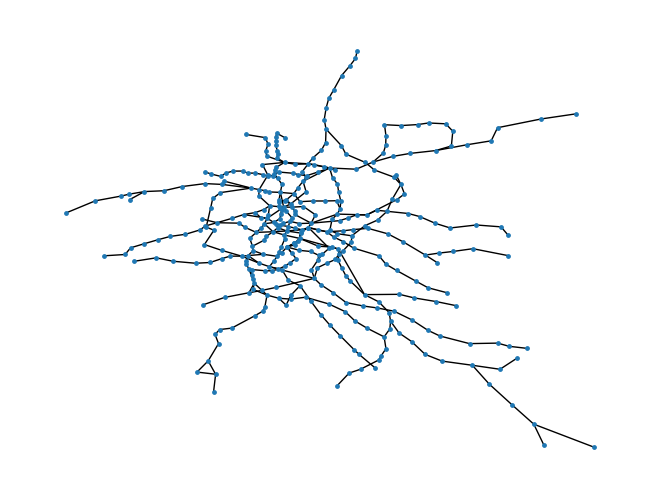

In [22]:
nx.draw(G,position,node_size = 6)

In [23]:
list(G.edges())

[('abbeyroad', 'stratfordhighstreet'),
 ('abbeyroad', 'westham'),
 ('westham', 'bromley-by-bow'),
 ('westham', 'plaistow'),
 ('westham', 'canningtown'),
 ('westham', 'stratford'),
 ('westham', 'starlane'),
 ('actoncentral', 'southacton'),
 ('actoncentral', 'willesdenjunction'),
 ('willesdenjunction', 'harlesden'),
 ('willesdenjunction', 'kensalgreen'),
 ('willesdenjunction', 'kensalrise'),
 ('willesdenjunction', 'shepherdsbush'),
 ('actontown', 'ealingcommon'),
 ('actontown', 'chiswickpark'),
 ('actontown', 'southealing'),
 ('actontown', 'turnhamgreen'),
 ('chiswickpark', 'turnhamgreen'),
 ('turnhamgreen', 'gunnersbury'),
 ('turnhamgreen', 'stamfordbrook'),
 ('turnhamgreen', 'hammersmith(dist&piccline)'),
 ('aldgate', 'towerhill'),
 ('aldgate', 'liverpoolstreet'),
 ('liverpoolstreet', 'bank'),
 ('liverpoolstreet', 'bethnalgreen'),
 ('liverpoolstreet', 'moorgate'),
 ('liverpoolstreet', 'aldgateeast'),
 ('aldgateeast', 'towerhill'),
 ('aldgateeast', 'whitechapel'),
 ('whitechapel', 'step

In [24]:
nx.is_connected(G)

True

In [71]:
degree_centrality = nx.degree_centrality(G)
degree_centrality

{'abbeyroad': 0.005434782608695652,
 'westham': 0.016304347826086956,
 'actoncentral': 0.005434782608695652,
 'willesdenjunction': 0.01358695652173913,
 'actontown': 0.010869565217391304,
 'chiswickpark': 0.005434782608695652,
 'turnhamgreen': 0.01358695652173913,
 'aldgate': 0.005434782608695652,
 'liverpoolstreet': 0.01358695652173913,
 'aldgateeast': 0.008152173913043478,
 'whitechapel': 0.010869565217391304,
 'allsaints': 0.005434782608695652,
 'poplar': 0.010869565217391304,
 'alperton': 0.005434782608695652,
 'parkroyal': 0.005434782608695652,
 'amersham': 0.002717391304347826,
 'chalfont&latimer': 0.008152173913043478,
 'anerley': 0.005434782608695652,
 'norwoodjunction': 0.005434782608695652,
 'angel': 0.005434782608695652,
 'oldstreet': 0.005434782608695652,
 'archway': 0.005434782608695652,
 'tufnellpark': 0.005434782608695652,
 'arnosgrove': 0.005434782608695652,
 'southgate': 0.005434782608695652,
 'arsenal': 0.005434782608695652,
 'finsburypark': 0.010869565217391304,
 'ba

In [27]:
neighbors_dict(G)

{'abbeyroad': ['stratfordhighstreet', 'westham'],
 'westham': ['bromley-by-bow',
  'plaistow',
  'canningtown',
  'stratford',
  'abbeyroad',
  'starlane'],
 'actoncentral': ['southacton', 'willesdenjunction'],
 'willesdenjunction': ['harlesden',
  'kensalgreen',
  'actoncentral',
  'kensalrise',
  'shepherdsbush'],
 'actontown': ['ealingcommon', 'chiswickpark', 'southealing', 'turnhamgreen'],
 'chiswickpark': ['actontown', 'turnhamgreen'],
 'turnhamgreen': ['gunnersbury',
  'chiswickpark',
  'stamfordbrook',
  'actontown',
  'hammersmith(dist&piccline)'],
 'aldgate': ['towerhill', 'liverpoolstreet'],
 'liverpoolstreet': ['bank',
  'bethnalgreen',
  'aldgate',
  'moorgate',
  'aldgateeast'],
 'aldgateeast': ['towerhill', 'whitechapel', 'liverpoolstreet'],
 'whitechapel': ['aldgateeast',
  'stepneygreen',
  'shoreditchhighstreet',
  'shadwell'],
 'allsaints': ['langdonpark', 'poplar'],
 'poplar': ['allsaints', 'westindiaquay', 'westferry', 'blackwall'],
 'alperton': ['sudburytown', 'par

In [28]:
# set labels to nodes
for n in G.nodes():
    G.nodes[n]['label'] = str(n)

In [29]:
G.nodes(data = True)

NodeDataView({'abbeyroad': {'label': 'abbeyroad'}, 'westham': {'label': 'westham'}, 'actoncentral': {'label': 'actoncentral'}, 'willesdenjunction': {'label': 'willesdenjunction'}, 'actontown': {'label': 'actontown'}, 'chiswickpark': {'label': 'chiswickpark'}, 'turnhamgreen': {'label': 'turnhamgreen'}, 'aldgate': {'label': 'aldgate'}, 'liverpoolstreet': {'label': 'liverpoolstreet'}, 'aldgateeast': {'label': 'aldgateeast'}, 'whitechapel': {'label': 'whitechapel'}, 'allsaints': {'label': 'allsaints'}, 'poplar': {'label': 'poplar'}, 'alperton': {'label': 'alperton'}, 'parkroyal': {'label': 'parkroyal'}, 'amersham': {'label': 'amersham'}, 'chalfont&latimer': {'label': 'chalfont&latimer'}, 'anerley': {'label': 'anerley'}, 'norwoodjunction': {'label': 'norwoodjunction'}, 'angel': {'label': 'angel'}, 'oldstreet': {'label': 'oldstreet'}, 'archway': {'label': 'archway'}, 'tufnellpark': {'label': 'tufnellpark'}, 'arnosgrove': {'label': 'arnosgrove'}, 'southgate': {'label': 'southgate'}, 'arsenal'

In [30]:
nt = Network('1000px', '1000px')
nt.from_nx(G) # imports graph from networkx
nt.show('T01_G.html')

In [61]:
# The graph will still plot but there is an error, could not resolve it
plot_G_pyvis(G, str_path + '\G.html')

OSError: [Errno 22] Invalid argument: './C:\\DSM160_CW1\\G.html'

In [31]:
# dictionary of degrees
G_degrees = invert_dict(dict(G.degree()))

In [32]:
degree_sequence = sorted([G.degree(n) for n in G.nodes()])
k, f_k = degree_histogram(degree_sequence, bln_normalised = True)

In [33]:
k

[1, 2, 3, 4, 5, 6, 7]

In [34]:
f_k

[0.07859078590785908,
 0.7127371273712737,
 0.08943089430894309,
 0.07588075880758807,
 0.013550135501355014,
 0.02168021680216802,
 0.008130081300813009]

### Question 1: Is the network weighted or unweighted? Directed or undirected

In [35]:
nx.is_weighted(G)

False

In [36]:
nx.is_directed(G)

False

### Question 3: What is the number of nodes and links in the network?

In [37]:
N = len(G.nodes()) # calculation for number of nodes
L = len(G.edges()) # calulation for number of edges

In [38]:
G.number_of_nodes() # networkX calculation

369

In [39]:
N

369

In [40]:
G.number_of_edges() # networkX calculation

430

In [41]:
L

430

In [42]:
l_nodes = list(G.nodes())
l_links = list(G.edges())
l_links

[('abbeyroad', 'stratfordhighstreet'),
 ('abbeyroad', 'westham'),
 ('westham', 'bromley-by-bow'),
 ('westham', 'plaistow'),
 ('westham', 'canningtown'),
 ('westham', 'stratford'),
 ('westham', 'starlane'),
 ('actoncentral', 'southacton'),
 ('actoncentral', 'willesdenjunction'),
 ('willesdenjunction', 'harlesden'),
 ('willesdenjunction', 'kensalgreen'),
 ('willesdenjunction', 'kensalrise'),
 ('willesdenjunction', 'shepherdsbush'),
 ('actontown', 'ealingcommon'),
 ('actontown', 'chiswickpark'),
 ('actontown', 'southealing'),
 ('actontown', 'turnhamgreen'),
 ('chiswickpark', 'turnhamgreen'),
 ('turnhamgreen', 'gunnersbury'),
 ('turnhamgreen', 'stamfordbrook'),
 ('turnhamgreen', 'hammersmith(dist&piccline)'),
 ('aldgate', 'towerhill'),
 ('aldgate', 'liverpoolstreet'),
 ('liverpoolstreet', 'bank'),
 ('liverpoolstreet', 'bethnalgreen'),
 ('liverpoolstreet', 'moorgate'),
 ('liverpoolstreet', 'aldgateeast'),
 ('aldgateeast', 'towerhill'),
 ('aldgateeast', 'whitechapel'),
 ('whitechapel', 'step

### Question 4: Is the network sparse?

In [43]:
density = 2*L/(N*(N-1)) # density calculation
density

0.006333215506068104

In [44]:
density == nx.density(G) # density calculation
density

0.006333215506068104

In [45]:
# the fewer edges are in a network, the sparser it is

### Question 6: What is the typical node degree of this network and why?

In [46]:
G_degrees = invert_dict(dict(G.degree()))
G_degrees

{1: ['amersham',
  'walthamstowcentral',
  'brixton',
  'chesham',
  'watford',
  'edgware',
  'lewisham',
  'beckton',
  'hammersmith(h&cline)',
  'heathrowterminal5',
  'highbarnet',
  'uxbridge',
  'woolwicharsenal',
  'millhilleast',
  'westcroydon',
  'cockfosters',
  'edgwareroad(districtline)',
  'richmond',
  'morden',
  'stanmore',
  'stratfordinternational',
  'newcross',
  'crystalpalace',
  'epping',
  'towergateway',
  'upminster',
  'watfordjunction',
  'westruislip',
  'wimbledon'],
 2: ['abbeyroad',
  'actoncentral',
  'chiswickpark',
  'aldgate',
  'allsaints',
  'alperton',
  'parkroyal',
  'anerley',
  'norwoodjunction',
  'angel',
  'oldstreet',
  'archway',
  'tufnellpark',
  'arnosgrove',
  'southgate',
  'arsenal',
  'greatportlandstreet',
  'regentspark',
  'balham',
  'tootingbec',
  'barbican',
  'farringdon',
  'upney',
  'barkingside',
  'fairlop',
  'westkensington',
  'bayswater',
  'becktonpark',
  'cyprus',
  'becontree',
  'dagenhamheathway',
  'belsize

In [47]:
# Assortativity

In [48]:
nx.degree_assortativity_coefficient(G)

0.13701185603013025

In [49]:
knn_dict = nx.average_degree_connectivity(G)
knn_pd_G = knn_dict_to_pd(knn_dict)
knn_pd_G

k       knn
0  1  2.793103
1  2  2.619772
2  3  2.828283
3  4  3.142857
4  5  3.040000
5  6  3.375000
6  7  2.714286

In [50]:
r, p_value = scipy.stats.pearsonr(list(knn_dict.keys()), list(knn_dict.values()))
r # *positive* correlation between k and knn

0.42953171391595585

In [51]:
# Median degree
median([G.degree(n) for n in G.nodes])

2

### Question 7: What is the average degree of the network? How does it compare to your answer to item (6)?

In [52]:
average_degree(G)

2.330623306233062

In [53]:
# average closeness centrality
deg_close = nx.closeness_centrality(G, wf_improved=True)
mean(list(deg_close.values()))

0.07700966107415387

### Question 8: Does the network have a core-periphery structure or a structure in which hubs are situated at the centre of star-like components? Justify

In [54]:
nx.periphery(G)

['heathrowterminal5', 'upminster']

## Question 9: How many connected components does the network have?

In [79]:
comps = sorted(nx.connected_components(G), key = len, reverse = True)
comps # connected components

[{'abbeyroad',
  'actoncentral',
  'actontown',
  'aldgate',
  'aldgateeast',
  'allsaints',
  'alperton',
  'amersham',
  'anerley',
  'angel',
  'archway',
  'arnosgrove',
  'arsenal',
  'bakerstreet',
  'balham',
  'bank',
  'barbican',
  'barking',
  'barkingside',
  'baronscourt',
  'bayswater',
  'beckton',
  'becktonpark',
  'becontree',
  'belsizepark',
  'bermondsey',
  'bethnalgreen',
  'blackfriars',
  'blackhorseroad',
  'blackwall',
  'bondstreet',
  'borough',
  'bostonmanor',
  'boundsgreen',
  'bowchurch',
  'bowroad',
  'brentcross',
  'brixton',
  'brockley',
  'bromley-by-bow',
  'brondesbury',
  'brondesburypark',
  'buckhursthill',
  'burntoak',
  'bushey',
  'caledonianroad',
  'caledonianroad&barnsbury',
  'camdenroad',
  'camdentown',
  'canadawater',
  'canarywharf',
  'canningtown',
  'cannonstreet',
  'canonbury',
  'canonspark',
  'carpenderspark',
  'chalfont&latimer',
  'chalkfarm',
  'chancerylane',
  'charingcross',
  'chesham',
  'chigwell',
  'chiswick

In [58]:
nx.number_connected_components(G)

1

In [206]:
GCC = nx.subgraph(G, (list(nx.connected_components(G))[0]))
invert_dict(dict(GCC.degree()))

{1: ['amersham',
  'walthamstowcentral',
  'brixton',
  'chesham',
  'watford',
  'edgware',
  'lewisham',
  'beckton',
  'hammersmith(h&cline)',
  'heathrowterminal5',
  'highbarnet',
  'uxbridge',
  'woolwicharsenal',
  'millhilleast',
  'westcroydon',
  'cockfosters',
  'edgwareroad(districtline)',
  'richmond',
  'morden',
  'stanmore',
  'stratfordinternational',
  'newcross',
  'crystalpalace',
  'epping',
  'towergateway',
  'upminster',
  'watfordjunction',
  'westruislip',
  'wimbledon'],
 2: ['abbeyroad',
  'actoncentral',
  'chiswickpark',
  'aldgate',
  'allsaints',
  'alperton',
  'parkroyal',
  'anerley',
  'norwoodjunction',
  'angel',
  'oldstreet',
  'archway',
  'tufnellpark',
  'arnosgrove',
  'southgate',
  'arsenal',
  'greatportlandstreet',
  'regentspark',
  'balham',
  'tootingbec',
  'barbican',
  'farringdon',
  'upney',
  'barkingside',
  'fairlop',
  'westkensington',
  'bayswater',
  'becktonpark',
  'cyprus',
  'becontree',
  'dagenhamheathway',
  'belsize

In [60]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [62]:
# Proportion of nodes having 5 or more connections
len(pd_C[pd_C['Degree']>=5])/len(pd_C)

NameError: name 'pd_C' is not defined

In [63]:
# Node with highest degree
highest_degree_node = max(G.nodes, key=G.degree)
G.degree(highest_degree_node)

7

In [64]:
highest_degree_node

'bakerstreet'

In [65]:
# Node with highest betweenness centrality
d_btw = nx.betweenness_centrality(G, normalized=True)
highest_betweenness_node = max(G.nodes, key=d_btw.get)
d_btw[highest_betweenness_node]

0.23987714098482976

In [66]:
# Top ten nodes by degree
top_ten_by_degree = sorted(G.nodes, key = G.degree, reverse=True)[:10]
top_ten_by_degree

['bakerstreet',
 'kingscrossstpancras',
 'stratford',
 'westham',
 'bank',
 'earlscourt',
 'paddington',
 'greenpark',
 'oxfordcircus',
 'canningtown']

In [67]:
# Top ten nodes by betweenness
top_ten_by_btw = sorted(G.nodes, key=d_btw.get, reverse=True)[:10]
top_ten_by_btw

['bank',
 'waterloo',
 'kingscrossstpancras',
 'greenpark',
 'bakerstreet',
 'euston',
 'stratford',
 'westminster',
 'finchleyroad',
 'liverpoolstreet']

In [68]:
# Top ten nodes by closeness
top_ten_by_cln = sorted(G.nodes, key=d_btw.get, reverse=True)[:10]
top_ten_by_cln

['bank',
 'waterloo',
 'kingscrossstpancras',
 'greenpark',
 'bakerstreet',
 'euston',
 'stratford',
 'westminster',
 'finchleyroad',
 'liverpoolstreet']

In [69]:
list(pd_C.nlargest(10, 'Degree', keep = 'all').index)

NameError: name 'pd_C' is not defined

In [217]:
pd_C['Closeness'].mean()
pd_C['Degree'].median()
pd_C.mean(axis=0)
pd_C.median(axis=0)

Degree         2.000000
Closeness      0.571429
Betweenness    0.500000
dtype: float64

In [218]:
# stations serving a single route:
pd_C[pd_C['Degree']==1]
len(pd_C[pd_C['Degree']==1]) # count how many

2

## Question 10: What are the top 10 stations in terms of degree, closeness and betweenness centrality

In [219]:
# pandas dataframe with 3 centrality concepts for the network
pd_C = G_centrality_pd(G)
pd_C

Degree  Closeness  Betweenness
abbeyroad             2   0.079688     0.000534
actoncentral          2   0.084812     0.042064
actontown             4   0.074858     0.084725
aldgate               2   0.094821     0.005587
aldgateeast           3   0.095436     0.009441
...                 ...        ...          ...
woodgrangepark        2   0.067659     0.026424
woodgreen             2   0.075194     0.026878
woodlane              2   0.066104     0.016215
woodsidepark          2   0.055774     0.010840
woolwicharsenal       1   0.058927     0.000000

[369 rows x 3 columns]

In [220]:
# Top ten nodes by degree, closeness and betweenness
pd_C.nlargest(10,'Degree', keep='all')

Degree  Closeness  Betweenness
bakerstreet               7   0.108108     0.219150
kingscrossstpancras       7   0.109884     0.223353
stratford                 7   0.090954     0.200934
bank                      6   0.108715     0.239877
canningtown               6   0.083070     0.104003
earlscourt                6   0.091270     0.125387
greenpark                 6   0.112953     0.219820
oxfordcircus              6   0.109524     0.060848
paddington                6   0.097252     0.059365
waterloo                  6   0.108683     0.225483
westham                   6   0.086527     0.113060

In [221]:
pd_C.nlargest(10,'Closeness', keep='all')

Degree  Closeness  Betweenness
greenpark                 6   0.112953     0.219820
westminster               4   0.110048     0.195798
bondstreet                4   0.109949     0.158123
kingscrossstpancras       7   0.109884     0.223353
oxfordcircus              6   0.109524     0.060848
bank                      6   0.108715     0.239877
waterloo                  6   0.108683     0.225483
bakerstreet               7   0.108108     0.219150
euston                    5   0.107101     0.206723
victoria                  4   0.106760     0.090489

In [222]:
pd_C.nlargest(10,'Betweenness', keep='all')

Degree  Closeness  Betweenness
bank                      6   0.108715     0.239877
waterloo                  6   0.108683     0.225483
kingscrossstpancras       7   0.109884     0.223353
greenpark                 6   0.112953     0.219820
bakerstreet               7   0.108108     0.219150
euston                    5   0.107101     0.206723
stratford                 7   0.090954     0.200934
westminster               4   0.110048     0.195798
finchleyroad              4   0.102251     0.177144
liverpoolstreet           5   0.104456     0.159510

### Question 11: Which stations are central according to all three centrality measures?

In [223]:
from operator import itemgetter

In [224]:
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
# Assign each to an attribute in your network
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

In [225]:
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 10 nodes by eigenvector centrality:")
for b in sorted_eigenvector[:10]:
    print(b)

Top 10 nodes by eigenvector centrality:
('oxfordcircus', 0.3968157978956346)
('greenpark', 0.3903624311661707)
('piccadillycircus', 0.30975629560797274)
('bondstreet', 0.28355136470871556)
('westminster', 0.22314485167327802)
('tottenhamcourtroad', 0.20996506946345467)
('bakerstreet', 0.2062259440657922)
('leicestersquare', 0.2059623772097717)
('waterloo', 0.18714423971611505)
('charingcross', 0.18061185439308267)


In [226]:
# Identifying most central nodes
# Node with highest degree
highest_degree_node = max(G.nodes, key=G.degree)
highest_degree_node

'bakerstreet'

In [227]:
G.degree(highest_degree_node)

7

In [228]:
# Node with highest betweenness centrality
d_btw = nx.betweenness_centrality(G, normalized=True)
highest_betweenness_node = max(G.nodes, key=d_btw.get)
d_btw[highest_betweenness_node]

0.23987714098482976

In [229]:
# Top five nodes by degree
top_five_by_degree = sorted(G.nodes, key=G.degree, reverse=True)[:5]
top_five_by_btw = sorted(G.nodes, key=d_btw.get, reverse=True)[:5]

In [230]:
# Average closeness centrality
d_cl = nx.closeness_centrality(G, wf_improved=True)
mean(list(d_cl.values())) # average closeness centrality

0.07700966107415387

In [231]:
# Median degree
median([G.degree(n) for n in G.nodes])

2

In [72]:
pd_C = G_centrality_pd(G)

In [73]:
# Node with highest degree
pd_C.nlargest(1,'Degree', keep='all')
list(pd_C.nlargest(1,'Degree', keep='all').index)

['bakerstreet', 'kingscrossstpancras', 'stratford']

In [74]:
# Node with highest betweenness centrality
pd_C.nlargest(1,'Betweenness', keep='all')

Degree  Closeness  Betweenness
bank       6   0.108715     0.239877

In [76]:
# mean and median values
pd_C['Closeness'].mean()
pd_C['Degree'].median()
pd_C.mean(axis=0)
pd_C.median(axis=0)

Degree         2.000000
Closeness      0.078016
Betweenness    0.021561
dtype: float64

### Question 12: Using the stations identified in item (10), which stations with high degree centrality are not betweenness-central? How do you interpret the role of such stations in the network?

In [236]:
# (Hint: You may convert the list of stations according
# to each centrality metric into sets, 
# using the set() function. Sets in Python have union, 
# intersection and difference methods, 
# allowing to combine sets in different ways)

In [232]:
# pandas dataframe with 3 centrality concepts for the network
pd_C = G_centrality_pd(G)
pd_C

Degree  Closeness  Betweenness
abbeyroad             2   0.079688     0.000534
actoncentral          2   0.084812     0.042064
actontown             4   0.074858     0.084725
aldgate               2   0.094821     0.005587
aldgateeast           3   0.095436     0.009441
...                 ...        ...          ...
woodgrangepark        2   0.067659     0.026424
woodgreen             2   0.075194     0.026878
woodlane              2   0.066104     0.016215
woodsidepark          2   0.055774     0.010840
woolwicharsenal       1   0.058927     0.000000

[369 rows x 3 columns]

In [237]:
# The stations with a high degree centrality that are not betweenness central
# play an important role of transmission of information (or peoople) between the important nodes
# this occurs if almost all stations are common to the main route

### Question 13: What is the proportion of stations where, at least, two different (train) lines intersect?

In [77]:
# Stations serving a single route:
pd_C[pd_C['Degree']==1]
len(pd_C[pd_C['Degree']==1]) # count how many

29

In [78]:
# Proportion of nodes having 2 or more connections
len(pd_C[pd_C['Degree']>=2])/len(pd_C)

0.9214092140921409

In [241]:
nodes_in_GCC = comps[0]
GCC = nx.subgraph(G, nodes_in_GCC)
neighbors_dict(GCC)
nx.is_connected(GCC) # the GCC is connected

True

### Question 14: Build and plot the node degree distibution for this network.  How does it relate to your answer to item (6)?

In [242]:
degree_histogram(degree_sequence, bln_normalised = True)

([1, 2, 3, 4, 5, 6, 7],
 [0.07859078590785908,
  0.7127371273712737,
  0.08943089430894309,
  0.07588075880758807,
  0.013550135501355014,
  0.02168021680216802,
  0.008130081300813009])

In [243]:
cum_probs = cumulative_prob(degree_sequence)

In [244]:
cum_probs_sn = {"{:.0e}".format(k):"{:.2e}".format(cum_probs[k])for k in cum_probs}

In [245]:
cum_probs

{1: 1.0,
 2: 0.9214092140921409,
 3: 0.2086720867208672,
 4: 0.11924119241192412,
 5: 0.04336043360433604,
 6: 0.02981029810298103,
 7: 0.008130081300813009}

In [246]:
cum_probs_sn

{'1e+00': '1.00e+00',
 '2e+00': '9.21e-01',
 '3e+00': '2.09e-01',
 '4e+00': '1.19e-01',
 '5e+00': '4.34e-02',
 '6e+00': '2.98e-02',
 '7e+00': '8.13e-03'}

In [247]:
degree_counts = Counter(degree_sequence)
degree_counts

Counter({1: 29, 2: 263, 3: 33, 4: 28, 5: 5, 6: 8, 7: 3})

In [248]:
sorted_degrees = sorted(list(degree_counts))
sorted_degrees

[1, 2, 3, 4, 5, 6, 7]

In [249]:
N = len(degree_sequence)
N

369

In [250]:
remaining = N
cumcount = {}
remaining/N

1.0

In [251]:
cum_prob = cumulative_prob(degree_sequence)
cum_probs

{1: 1.0,
 2: 0.9214092140921409,
 3: 0.2086720867208672,
 4: 0.11924119241192412,
 5: 0.04336043360433604,
 6: 0.02981029810298103,
 7: 0.008130081300813009}

In [252]:
# plot cumulative degree distributions
# obtain degree sequence
degree_sequence = sorted([G.degree(n) for n in G.nodes()], reverse=True)

In [253]:
# obtain degree histogram values
plot_x, plot_y = degree_histogram(degree_sequence, bln_normalised = True)

In [254]:
# obtain cumulative probabilities
cum_probs = cumulative_prob(degree_sequence)
cum_probs

{1: 1.0,
 2: 0.9214092140921409,
 3: 0.2086720867208672,
 4: 0.11924119241192412,
 5: 0.04336043360433604,
 6: 0.02981029810298103,
 7: 0.008130081300813009}

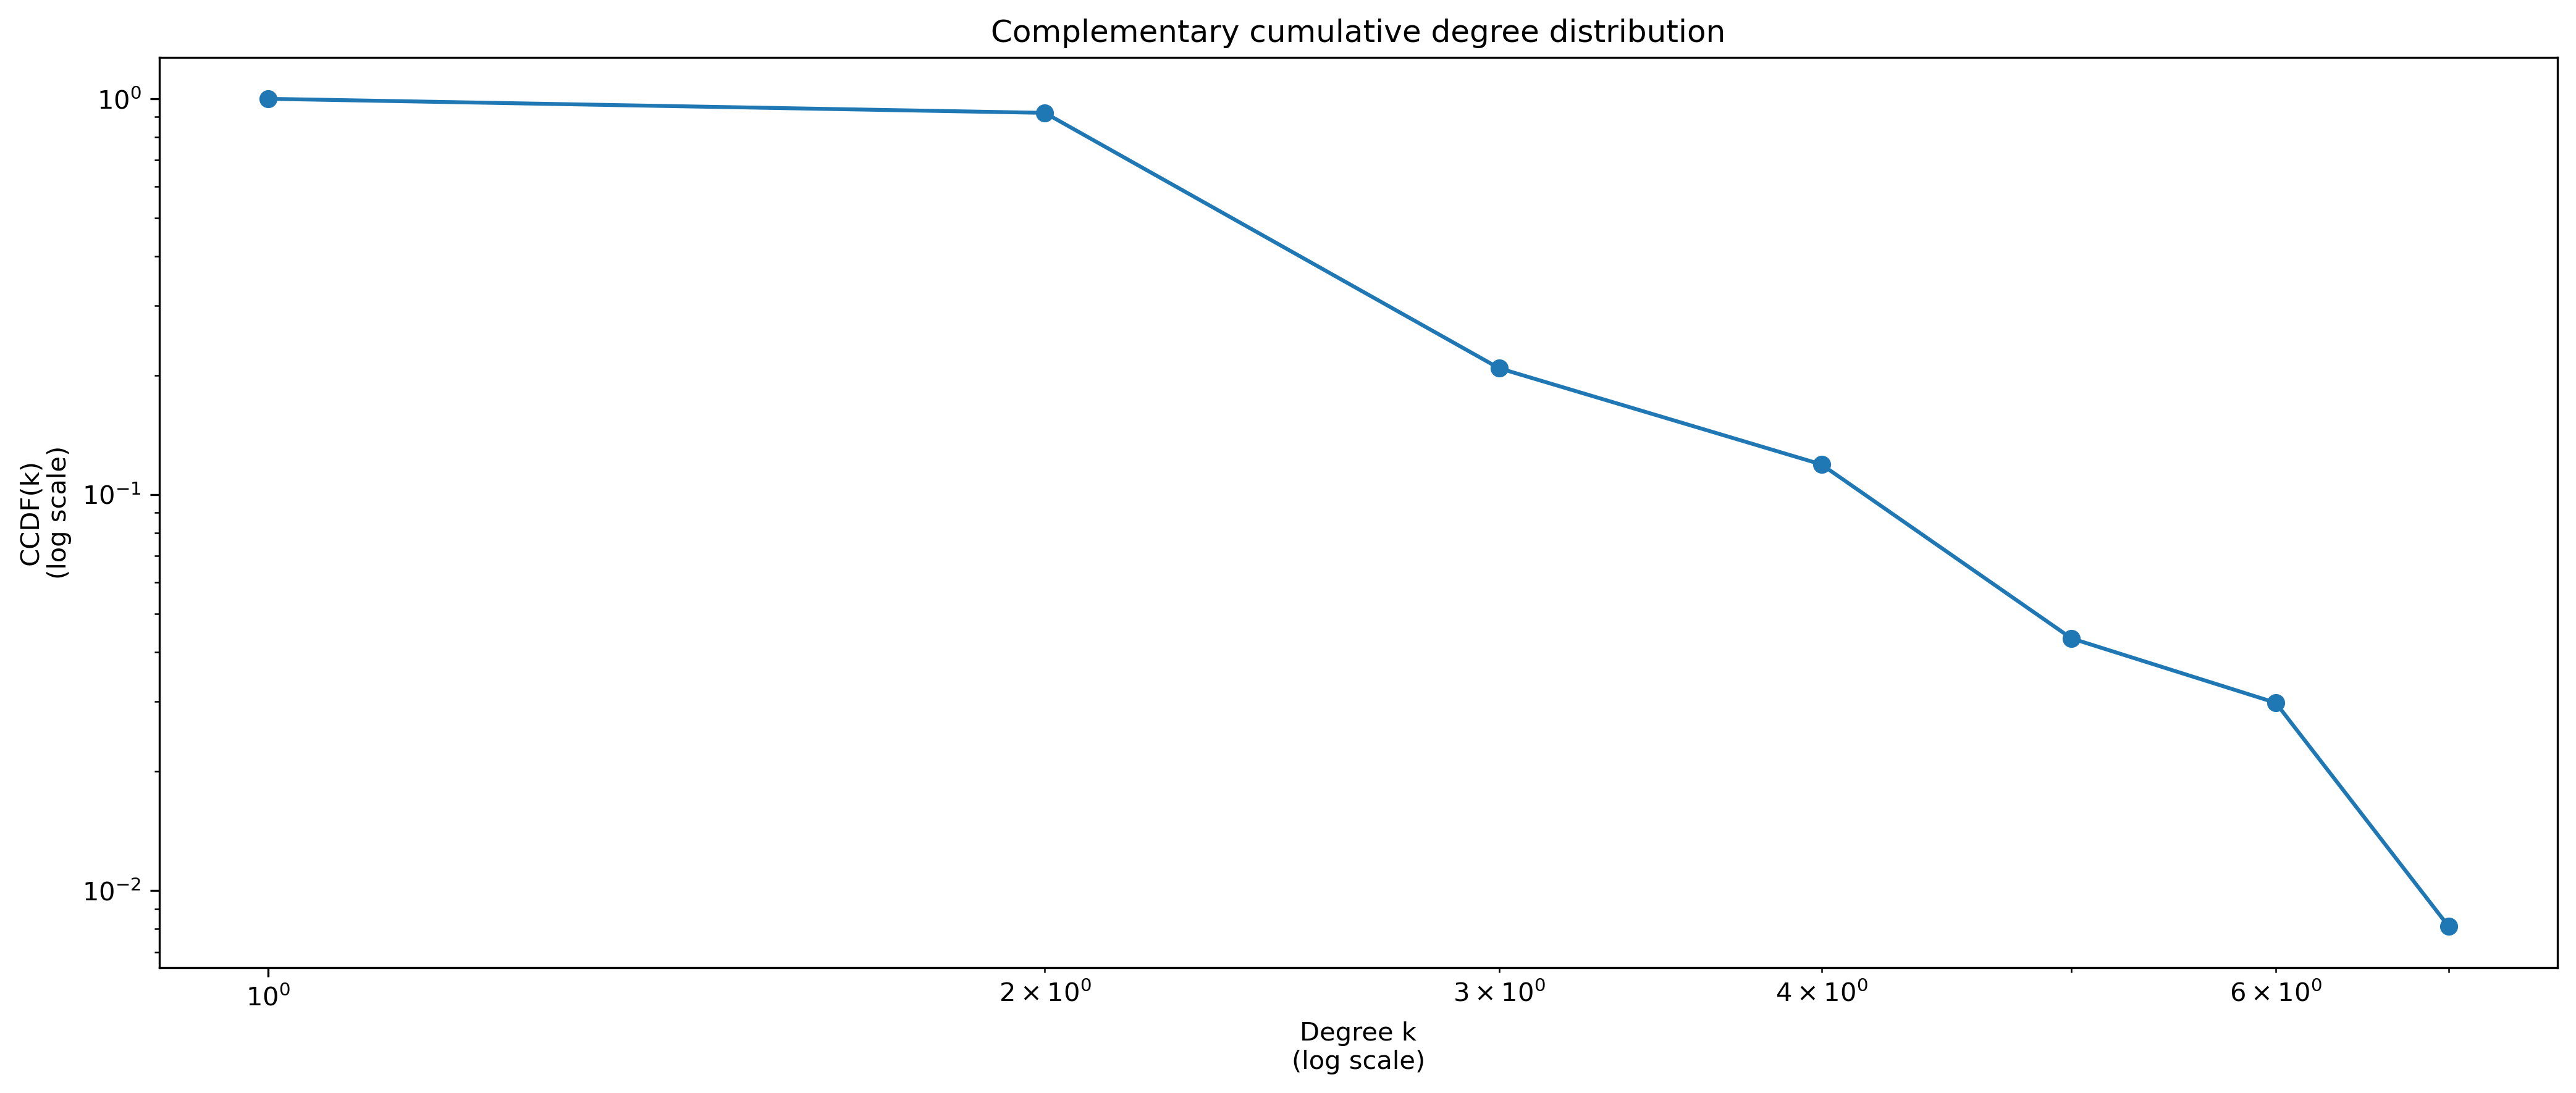

In [255]:
# plot the cumulative degree distribution
plt.figure(figsize=(14,6), dpi=300, tight_layout=True)
plt.title('Complementary cumulative degree distribution')
plt.xlabel('Degree k\n(log scale)')
plt.ylabel('CCDF(k)\n(log scale)')
plt.xscale('log')
plt.yscale('log')
plt.plot(cum_probs.keys(), cum_probs.values(), marker='o')
plt.savefig(str_path + '/G_cum_degree_hist.png')

In [256]:
# obtain degree sequence
degree_sequence = sorted([G.degree(n)for n in G.nodes()], reverse=True)

In [257]:
# obtain degree histogram values
plot_x, plot_y = degree_histogram(degree_sequence, bln_normalised = True)
plot_x, plot_y

([1, 2, 3, 4, 5, 6, 7],
 [0.07859078590785908,
  0.7127371273712737,
  0.08943089430894309,
  0.07588075880758807,
  0.013550135501355014,
  0.02168021680216802,
  0.008130081300813009])

In [258]:
cum_probs = cumulative_prob(degree_sequence)
cum_probs

{1: 1.0,
 2: 0.9214092140921409,
 3: 0.2086720867208672,
 4: 0.11924119241192412,
 5: 0.04336043360433604,
 6: 0.02981029810298103,
 7: 0.008130081300813009}

In [259]:
cum_probs.values()

dict_values([1.0, 0.9214092140921409, 0.2086720867208672, 0.11924119241192412, 0.04336043360433604, 0.02981029810298103, 0.008130081300813009])

### Question 15: How many steps does it take, on average, to go from one station to another using shortest paths?

In [261]:
# Average shortest-path length
dict(nx.shortest_path_length(G))

{'abbeyroad': {'abbeyroad': 0,
  'westham': 1,
  'stratfordhighstreet': 1,
  'stratford': 2,
  'bromley-by-bow': 2,
  'canningtown': 2,
  'starlane': 2,
  'plaistow': 2,
  'hackneywick': 3,
  'leyton': 3,
  'uptonpark': 3,
  'stratfordinternational': 3,
  'royalvictoria': 3,
  'northgreenwich': 3,
  'eastindia': 3,
  'mileend': 3,
  'westsilvertown': 3,
  'puddingmilllane': 3,
  'bowroad': 3,
  'bowchurch': 4,
  'blackwall': 4,
  'bethnalgreen': 4,
  'homerton': 4,
  'customhouse': 4,
  'leytonstone': 4,
  'pontoondock': 4,
  'eastham': 4,
  'canarywharf': 4,
  'stepneygreen': 4,
  'princeregent': 5,
  'poplar': 5,
  'hackneycentral': 5,
  'heronquays': 5,
  'londoncityairport': 5,
  'wanstead': 5,
  'canadawater': 5,
  'snaresbrook': 5,
  'westindiaquay': 5,
  'liverpoolstreet': 5,
  'devonsroad': 5,
  'whitechapel': 5,
  'barking': 5,
  'redbridge': 6,
  'westferry': 6,
  'upney': 6,
  'royalalbert': 6,
  'woodgrangepark': 6,
  'dalstonkingsland': 6,
  'bermondsey': 6,
  'kinggeorgev

In [ ]:
dict(nx.shortest_path(G))

In [ ]:
pd_SPL_G = SPL_dict_to_pd(dict(nx.shortest_path_length(G)))
pd_SPL_G

In [ ]:
nx.is_connected(G)

In [151]:
if nx.is_connected(G):
        print('average path length: {}'.format(nx.average_shortest_path_length(G)))
        print('average diameter: {}'.format(nx.diameter(G)))

average path length: 2.0
average diameter: 4


### Question 16: What is the shortest path to go from the first to the second most central station by degree? What is the path length?

In [271]:
nx.shortest_path_length(G, 'bakerstreet', 'kingscrossstpancras')

3

### Question 17: Amongst the top 5 stations by betweeness centrality, which are directly connected or have at most one intermediate station between them?

In [281]:
# Top five nodes by betweenness
top_five_by_btw = sorted(G.nodes, key=d_btw.get, reverse=True)[:5]
top_five_by_btw

['bank', 'waterloo', 'kingscrossstpancras', 'greenpark', 'bakerstreet']

In [291]:
# Top five stations 
top_five =['bank', 'waterloo', 'kingscrossstpancras', 'greenpark', 'bakerstreet']
k = G.subgraph(top_five)

In [292]:
list(k.edges())

[('waterloo', 'bank')]

In [293]:
comps = sorted(nx.connected_components(k), key = len, reverse = True)
comps

[{'bank', 'waterloo'}, {'greenpark'}, {'kingscrossstpancras'}, {'bakerstreet'}]

In [295]:
nodes_in_top_five = comps[0]
nodes_in_top_five

{'bank', 'waterloo'}

In [297]:
ABC = nx.subgraph(G, nodes_in_top_five)
neighbors_dict(ABC)

{'bank': ['waterloo'], 'waterloo': ['bank']}

In [298]:
nx.is_connected(ABC)

True

### Question 18: You want to perform some robustness tests on this transport network by simulating attacks which disrupt one station at a time. In particular, you want to compare the vulnerability of the network when nodes are removed one by one in decreasing order of (i) their degree, as opposed to (ii) their betweenness centrality. Which strategy – (i) or (ii) – will be faster in reducing to less than 80% the proportion of nodes in the (largest) connected component? Please justify. 

In [84]:
import random

In [85]:
N = G.number_of_nodes()
prop_removed = 0.8 # remove 80% of nodes at a time
M = int(prop_removed*N)
share_nodes_removed = range(0, 100, int(prop_removed*100))
#
pd_full = pd.DataFrame({'share_removed':list(share_nodes_removed)})
#
for i in range(0,100):
    C = G.copy()
    random_attack_core_proportions = []
    for nodes_removed in share_nodes_removed:
        # Measure the relative size of the network core
        core = list(nx.connected_components(C))[0]
        core_proportion = len(core)/N
        random_attack_core_proportions.append(core_proportion)
        # If there are more than M nodes
        if C.number_of_nodes() > M:
            #select M nodes at random and remove them
            nodes_to_remove = random.sample(list(C.nodes), M)
            C.remove_nodes_from(nodes_to_remove)
            #
            pd_iter = pd.DataFrame({'run_' + str(i):random_attack_core_proportions})
            pd_full = pd.concat([pd_full, pd_iter], axis=1)
            #
list(share_nodes_removed) # cumulative number of nodes removed
random_attack_core_proportions = list(pd_full.drop('share_removed', axis=1).mean(axis=1))
random_attack_core_proportions # size of connected component relative to full network

[1.0, nan]

In [87]:
# accumulate in dictionary for all airlines
d_random_fail= dict(zip(list(share_nodes_removed),random_attack_core_proportions))
d_random_fail

{0: 1.0, 80: nan}